Snowpark library is a SNowflake API that can be used for processing and querying data, using which you can build applications 
that process data in Snowflake without moving data to the system where your **application code runs**. 
Snowpark has many kool features , you can check more on snowpark here "https://docs.snowflake.com/en/developer-guide/snowpark/index.html".


This is example article, I will create a simple Machine learning model (decision-tree model) and run it in the snowflake environment using the snowpark
library. The dataset used for the example is the **Iris** flower dataset, which you can easily download from the internet.


**Prerequiste**
1. Snowflake Account
2. Python Libraries - Snowpark, Scikit-Learn
3. Iris Dataset






We will create a user-defined functions (UDFs) with the decision-tree model and using **Snowpark** will push the code to the snowflake server;
and we also see how we can operate on the data.

To know more about scikit-learn, Decision-tree model refer
[here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [3]:
# First lets connect to snowflake account


#import the snowflake libraries
from snowflake.snowpark.session import Session
import getpass

#Authentication

user = input("Username:")
pwd = getpass.getpass("Password for " + user + ":")
wh = input("Warehouse:") # or create a new warehouse an runtime
role = input("Role:")


connection_parameters = {
  "account": "sfpscogs-rp022az",
  "user": user,
  "password": pwd,
  "role": role,
  "warehouse": wh ,
  "database": "SNOWPARK_DEMO",
  "schema": "ML_DB"}

session = Session.builder.configs(connection_parameters).create()


Username:rpegu
Password for rpegu:········
Warehouse:demo_wh
Role:demo_role


In [4]:
# create a stage to sava and store the model file

session.sql("CREATE STAGE if not exists ML_MODELS ").collect()

[Row(status='ML_MODELS already exists, statement succeeded.')]

In [5]:
import pandas as pd
import numpy as np
pd.DataFrame(session.sql('SHOW STAGES').collect())

,created_on,name,database_name,schema_name,url,has_credentials,has_encryption_key,owner,comment,region,type,cloud,notification_channel,storage_integration
0,2023-01-27 08:49:38.170000-08:00,ML_MODELS,SNOWPARK_DEMO,ML_DB,,N,N,DEMO_ROLE,,None,INTERNAL,None,None,None


In [6]:
## create an iris dataframe, get the data from SNOWPARK_DEMO 
sdf_iris = session.table('IRIS')

sdf_iris.show(5)

--------------------------------------------------------------------------------------------
|"ID"  |"SEPALLENGTHCM"  |"SEPALWIDTHCM"  |"PETALLENGTHCM"  |"PETALWIDTHCM"  |"SPECIES"    |
--------------------------------------------------------------------------------------------
|1     |5.1              |3.5             |1.4              |0.2             |Iris-setosa  |
|2     |4.9              |3.0             |1.4              |0.2             |Iris-setosa  |
|3     |4.7              |3.2             |1.3              |0.2             |Iris-setosa  |
|4     |4.6              |3.1             |1.5              |0.2             |Iris-setosa  |
|5     |5.0              |3.6             |1.4              |0.2             |Iris-setosa  |
--------------------------------------------------------------------------------------------



In [47]:
# get the columns
sdf_iris.columns

['ID',
 'SEPALLENGTHCM',
 'SEPALWIDTHCM',
 'PETALLENGTHCM',
 'PETALWIDTHCM',
 'SPECIES']

In [49]:
# let quickly check the disstribution of dataset

sdf_iris.group_by('SPECIES').count().to_pandas()

,SPECIES,COUNT
0,Iris-setosa,50
1,Iris-versicolor,50
2,Iris-virginica,50


**About the Data**
    
    

In [7]:
## loading the data in pandas
df_iris = session.table('IRIS').to_pandas()
df_iris.describe()

,ID,SEPALLENGTHCM,SEPALWIDTHCM,PETALLENGTHCM,PETALWIDTHCM
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


Let's quickly visualize the data using the seaborn library

<AxesSubplot: xlabel='SEPALLENGTHCM', ylabel='SEPALWIDTHCM'>

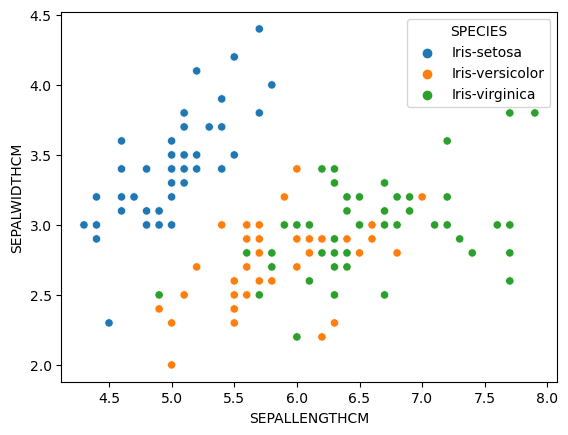

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot( x="SEPALLENGTHCM", y="SEPALWIDTHCM",data = df_iris, hue = 'SPECIES', legend= True)

Lets create a simple decision-tree model.

In [12]:
# create a python function for decision tree model 
import snowflake.snowpark.types as T

def sproc_training_decision_tree_model(session: Session, data: str, features_col: list,\
                                       target_col:list,model_name: str) -> T.Variant: 
    #loadinf the train data to pandas df

    df = session.table(data).to_pandas()
    X = df[features_col]
    y = df[target_col]
    from sklearn.model_selection import train_test_split
    X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 7)
    
    #Actual model training
    from sklearn import tree
    classifier = tree.DecisionTreeClassifier()
    classifier.fit(X_train,y_train)
    predictions=classifier.predict(X_test)
    
    from sklearn.metrics import accuracy_score
    score = accuracy_score(y_test,predictions)*100
    from joblib import dump
    dump(classifier,'/tmp/'+model_name)
    #puting the saved model into stage.
    session.file.put('/tmp/'+ model_name,'@ML_MODELS',auto_compress=False, overwrite=True)
    
    return score

To run the model in snowpark, lets register a named UDF. To do this, use one of the following:

The register method, in the UDFRegistration class, with the name argument.
    
    
    

In [13]:
## Registering the function 
sproc_training_decision_tree_model = session.sproc.register(func=sproc_training_decision_tree_model,\
                                                            name = 'sproc_train_classifer_model',\
                                                            is_permanent=True,\
                                                            replace=True,\
                                                            stage_location='@ML_MODELS',\
                                                            packages=['snowflake-snowpark-python','scikit-learn','joblib'])


Now let's call the UDF

In [16]:
data='IRIS'
#get features columns
feature_cols =['SEPALLENGTHCM', 'SEPALWIDTHCM', 'PETALLENGTHCM', 'PETALWIDTHCM']
target_col = ['SPECIES']
model_name = 'classifier_model.sav'

score = sproc_training_decision_tree_model(data, feature_cols,  target_col, model_name,  session=session)

# what is score of the model ?


print("Accuracy:" , score)


Accuracy: 93.33333333333333


So our model has **accuracy** on 93%.

Now lets see whats there in our stage.

In [20]:
session.sql("list @ML_MODELS ").collect()

[Row(name='ml_models/classifier_model.sav', size=2480, md5='0465b3d4a598475fe28e6eee28add9d5', last_modified='Mon, 30 Jan 2023 16:52:20 GMT')]

NameError: name 'X' is not defined

In [64]:
# Define a simple scoring function
def udf_decision_tree_model(*args) -> str:
    import os
    import sys
    from joblib import load
    # file-dependencies of UDFs are available in snowflake_import_directory
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    
    model_name = 'classifier_model.sav'
    
    #loading the model
    model = load(import_dir+model_name)
    species_types = model.predict(pd.DataFrame([args]))[0]
    return species_types



In [65]:
# Register UDF
udf_decision_tree_model = session.udf.register(func=udf_decision_tree_model, 
                                                    name="udf_decision_tree_model", 
                                                    stage_location='@ML_MODELS',
                                                    input_types=[T.FloatType()]*len(feature_cols),
                                                    return_type = T.StringType(),
                                                    replace=True, 
                                                    is_permanent=True, 
                                                    imports=['@ML_MODELS/classifier_model.sav'],
                                                    packages=['scikit-learn==1.1.3','pandas','joblib'], 
                                                    session=session)


In [66]:
# Lets disable result-cache for a moment to see true scoring-performance
session.sql('ALTER SESSION SET USE_CACHED_RESULT = FALSE').collect()

[Row(status='Statement executed successfully.')]

Predict the speices types of new specimen. 

In [74]:
# Create a DataFrame with 4 columns, 'SEPALLENGTHCM', 'SEPALWIDTHCM', 'PETALLENGTHCM', 'PETALWIDTHCM'
sdf_iris = session.create_dataframe([[5.1, 3.4, 1.4, 0.2]], schema=['SEPALLENGTHCM', 'SEPALWIDTHCM', 'PETALLENGTHCM', 'PETALWIDTHCM'])
sdf_iris.show()



-----------------------------------------------------------------------
|"SEPALLENGTHCM"  |"SEPALWIDTHCM"  |"PETALLENGTHCM"  |"PETALWIDTHCM"  |
-----------------------------------------------------------------------
|5.1              |3.4             |1.4              |0.2             |
-----------------------------------------------------------------------



In [75]:
predict_sdf = sdf_iris.with_column('PREDICTION',udf_decision_tree_model(*feature_cols))

In [76]:
predict_sdf.show()

--------------------------------------------------------------------------------------
|"SEPALLENGTHCM"  |"SEPALWIDTHCM"  |"PETALLENGTHCM"  |"PETALWIDTHCM"  |"PREDICTION"  |
--------------------------------------------------------------------------------------
|5.1              |3.4             |1.4              |0.2             |Iris-setosa   |
--------------------------------------------------------------------------------------



You can stored the outcome into a table 



In [77]:
predict_sdf.write.save_as_table(table_name='PREDICTED_IRIS_SAMPLE', mode='append')